In [1]:
import os
import math
import numpy as np
import pandas as pd
from numpy import abs
from numpy import log
from numpy import sign
from scipy import stats
from scipy.stats import rankdata
from pypinyin import lazy_pinyin
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 中文字体设置
plt.rcParams['axes.unicode_minus'] = False
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
# region Auxiliary functions
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def stddev(df, window=10):
    return df.rolling(window).std()

def correlation(x, y, window=10):
    return x.rolling(window).corr(y)

def covariance(x, y, window=10):
    return x.rolling(window).cov(y)

def rolling_rank(na):
    return rankdata(na)[-1]

def ts_rank(df, window=10):
    return df.rolling(window).apply(rolling_rank)

def rolling_prod(na):
    return np.prod(na)

def product(df, window=10):
    return df.rolling(window).apply(rolling_prod)

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(pct=True)

def scale(df, k=1):
    return df.mul(k).div(np.abs(df).sum())

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 

def ts_argmin(df, window=10):
    return df.rolling(window).apply(np.argmin) + 1

def decay_linear(df, period=10):
    # Clean data
    if df.isnull().values.any():
        df.fillna(method='ffill', inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(value=0, inplace=True)
    na_lwma = np.zeros_like(df)
    na_lwma[:period, :] = df.iloc[:period, :] 
    na_series = df.values

    divisor = period * (period + 1) / 2
    y = (np.arange(period) + 1) * 1.0 / divisor
    # Estimate the actual lwma with the actual close.
    # The backtest engine should assure to be snooping bias free.
    for row in range(period - 1, df.shape[0]):
        x = na_series[row - period + 1: row + 1, :]
        na_lwma[row, :] = (np.dot(x.T, y))
    return pd.DataFrame(na_lwma, index=df.index, columns=['CLOSE'])  
# endregion
class Alphas(object):
    def __init__(self, df_data):
        self.open = df_data['open'] 
        self.high = df_data['high'] 
        self.low = df_data['low']   
        self.close = df_data['close'] 
        self.volume = df_data['volume']*100 
        self.returns = df_data['pctchange'] 
        self.vwap = (df_data['amount']*1000)/(df_data['volume']*100+1) 
            
    # Alpha#1	 (rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) -0.5)
    # def alpha001(self):
    #     inner = self.close
    #     inner.loc[self.returns < 0,:] = stddev(self.returns, 20)
    #     return rank(ts_argmax(inner ** 2, 5))
        
    # Alpha#2	 (-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))
    def alpha002(self):
        df = -1 * correlation(rank(delta(log(self.volume), 2)), rank((self.close - self.open) / self.open), 6)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
        
    # Alpha#3	 (-1 * correlation(rank(open), rank(volume), 10))
    def alpha003(self):
        df = -1 * correlation(rank(self.open), rank(self.volume), 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
        
    # Alpha#4	 (-1 * Ts_Rank(rank(low), 9))
    def alpha004(self):
        return -1 * ts_rank(rank(self.low), 9)
        
    # Alpha#5	 (rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))
    def alpha005(self):
        return  (rank((self.open - (sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
        
    # Alpha#6	 (-1 * correlation(open, volume, 10))
    def alpha006(self):
        df = -1 * correlation(self.open, self.volume, 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)

    # Alpha#7	 ((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1* 1))
    def alpha007(self):
        adv20 = sma(self.volume, 20)
        alpha = -1 * ts_rank(abs(delta(self.close, 7)), 60) * sign(delta(self.close, 7))
        alpha[adv20 >= self.volume] = -1
        return alpha

    # Alpha#8	 (-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)),10))))
    def alpha008(self):
        return -1 * (rank(((ts_sum(self.open, 5) * ts_sum(self.returns, 5)) -delay((ts_sum(self.open, 5) * ts_sum(self.returns, 5)), 10))))

    # Alpha#9	 ((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ?delta(close, 1) : (-1 * delta(close, 1))))
    def alpha009(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 5) > 0
        cond_2 = ts_max(delta_close, 5) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha

    # Alpha#10	 rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0)? delta(close, 1) : (-1 * delta(close, 1)))))
    def alpha010(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 4) > 0
        cond_2 = ts_max(delta_close, 4) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha

    # Alpha#11	 ((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) *rank(delta(volume, 3)))
    def alpha011(self):
        return ((rank(ts_max((self.vwap - self.close), 3)) + rank(ts_min((self.vwap - self.close), 3))) *rank(delta(self.volume, 3)))

    # Alpha#12	 (sign(delta(volume, 1)) * (-1 * delta(close, 1)))
    def alpha012(self):
        return sign(delta(self.volume, 1)) * (-1 * delta(self.close, 1))

    # Alpha#13	 (-1 * rank(covariance(rank(close), rank(volume), 5)))
    def alpha013(self):
        return -1 * rank(covariance(rank(self.close), rank(self.volume), 5))

    # Alpha#14	 ((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))
    def alpha014(self):
        df = correlation(self.open, self.volume, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * rank(delta(self.returns, 3)) * df

    # Alpha#15	 (-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3))
    def alpha015(self):
        df = correlation(rank(self.high), rank(self.volume), 3)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * ts_sum(rank(df), 3)

    # Alpha#16	 (-1 * rank(covariance(rank(high), rank(volume), 5)))
    def alpha016(self):
        return -1 * rank(covariance(rank(self.high), rank(self.volume), 5))

    # Alpha#17	 (((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) *rank(ts_rank((volume / adv20), 5)))
    def alpha017(self):
        adv20 = sma(self.volume, 20)
        return -1 * (rank(ts_rank(self.close, 10)) *rank(delta(delta(self.close, 1), 1)) *rank(ts_rank((self.volume / adv20), 5)))
        
    # Alpha#18	 (-1 * rank(((stddev(abs((close - open)), 5) + (close - open)) + correlation(close, open,10))))
    def alpha018(self):
        df = correlation(self.close, self.open, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * (rank((stddev(abs((self.close - self.open)), 5) + (self.close - self.open)) +
                            df))

    # Alpha#19	 ((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + sum(returns,250)))))
    def alpha019(self):
        return ((-1 * sign((self.close - delay(self.close, 7)) + delta(self.close, 7))) *
                (1 + rank(1 + ts_sum(self.returns, 250))))

    # Alpha#20	 (((-1 * rank((open - delay(high, 1)))) * rank((open - delay(close, 1)))) * rank((open -delay(low, 1))))
    def alpha020(self):
        return -1 * (rank(self.open - delay(self.high, 1)) *
                        rank(self.open - delay(self.close, 1)) *
                        rank(self.open - delay(self.low, 1)))

    # Alpha#21	 ((((sum(close, 8) / 8) + stddev(close, 8)) < (sum(close, 2) / 2)) ? (-1 * 1) : (((sum(close,2) / 2) < ((sum(close, 8) / 8) - stddev(close, 8))) ? 1 : (((1 < (volume / adv20)) || ((volume /adv20) == 1)) ? 1 : (-1 * 1))))
    def alpha021(self):
        cond_1 = sma(self.close, 8) + stddev(self.close, 8) < sma(self.close, 2)
        cond_2 = sma(self.volume, 20) / self.volume < 1
        alpha = pd.DataFrame(np.ones_like(self.close), index=self.close.index
                                )
    #        alpha = pd.DataFrame(np.ones_like(self.close), index=self.close.index,
    #                             columns=self.close.columns)
        alpha[cond_1 | cond_2] = -1
        return alpha

    # Alpha#22	 (-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20))))
    def alpha022(self):
        df = correlation(self.high, self.volume, 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * delta(df, 5) * rank(stddev(self.close, 20))

    # Alpha#24	 ((((delta((sum(close, 100) / 100), 100) / delay(close, 100)) < 0.05) ||((delta((sum(close, 100) / 100), 100) / delay(close, 100)) == 0.05)) ? (-1 * (close - ts_min(close,100))) : (-1 * delta(close, 3)))
    def alpha024(self):
        cond = delta(sma(self.close, 100), 100) / delay(self.close, 100) <= 0.05
        alpha = -1 * delta(self.close, 3)
        alpha[cond] = -1 * (self.close - ts_min(self.close, 100))
        return alpha

    # Alpha#25	 rank(((((-1 * returns) * adv20) * vwap) * (high - close)))
    def alpha025(self):
        adv20 = sma(self.volume, 20)
        return rank(((((-1 * self.returns) * adv20) * self.vwap) * (self.high - self.close)))

    # Alpha#26	 (-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))
    def alpha026(self):
        df = correlation(ts_rank(self.volume, 5), ts_rank(self.high, 5), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * ts_max(df, 3)

    # Alpha#27	 ((0.5 < rank((sum(correlation(rank(volume), rank(vwap), 6), 2) / 2.0))) ? (-1 * 1) : 1)
    #可能存在问题，我自己的数据测试了很多次值全为1，可能需要调整6,2这些参数？
    def alpha027(self):
        alpha = rank((sma(correlation(rank(self.volume), rank(self.vwap), 6), 2) / 2.0))
        alpha[alpha > 0.5] = -1
        alpha[alpha <= 0.5]=1
        return alpha  

    # Alpha#28	 scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))
    def alpha028(self):
        adv20 = sma(self.volume, 20)
        df = correlation(adv20, self.low, 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return scale(((df + ((self.high + self.low) / 2)) - self.close))

    # Alpha#29	 (min(product(rank(rank(scale(log(sum(ts_min(rank(rank((-1 * rank(delta((close - 1),5))))), 2), 1))))), 1), 5) + ts_rank(delay((-1 * returns), 6), 5))
    def alpha029(self):
        return (ts_min(rank(rank(scale(log(ts_sum(rank(rank(-1 * rank(delta((self.close - 1), 5)))), 2))))), 5) +
                ts_rank(delay((-1 * self.returns), 6), 5))

    # Alpha#30	 (((1.0 - rank(((sign((close - delay(close, 1))) + sign((delay(close, 1) - delay(close, 2)))) +sign((delay(close, 2) - delay(close, 3)))))) * sum(volume, 5)) / sum(volume, 20))
    def alpha030(self):
        delta_close = delta(self.close, 1)
        inner = sign(delta_close) + sign(delay(delta_close, 1)) + sign(delay(delta_close, 2))
        return ((1.0 - rank(inner)) * ts_sum(self.volume, 5)) / ts_sum(self.volume, 20)

    # Alpha#31	 ((rank(rank(rank(decay_linear((-1 * rank(rank(delta(close, 10)))), 10)))) + rank((-1 *delta(close, 3)))) + sign(scale(correlation(adv20, low, 12))))
    def alpha031(self):
        adv20 = sma(self.volume, 20)
        df = correlation(adv20, self.low, 12).replace([-np.inf, np.inf], 0).fillna(value=0)         
        p1=rank(rank(rank(decay_linear((-1 * rank(rank(delta(self.close, 10)))).to_frame(), 10)))) 
        p2=rank((-1 * delta(self.close, 3)))
        p3=sign(scale(df))
        
        return p1.CLOSE+p2+p3

    # Alpha#32	 (scale(((sum(close, 7) / 7) - close)) + (20 * scale(correlation(vwap, delay(close, 5),230))))
    def alpha032(self):
        return scale(((sma(self.close, 7) / 7) - self.close)) + (20 * scale(correlation(self.vwap, delay(self.close, 5),230)))

    # Alpha#33	 rank((-1 * ((1 - (open / close))^1)))
    def alpha033(self):
        return rank(-1 + (self.open / self.close))

    # Alpha#34	 rank(((1 - rank((stddev(returns, 2) / stddev(returns, 5)))) + (1 - rank(delta(close, 1)))))
    def alpha034(self):
        inner = stddev(self.returns, 2) / stddev(self.returns, 5)
        inner = inner.replace([-np.inf, np.inf], 1).fillna(value=1)
        return rank(2 - rank(inner) - rank(delta(self.close, 1)))

    # Alpha#35	 ((Ts_Rank(volume, 32) * (1 - Ts_Rank(((close + high) - low), 16))) * (1 -Ts_Rank(returns, 32)))
    def alpha035(self):
        return ((ts_rank(self.volume, 32) *
                    (1 - ts_rank(self.close + self.high - self.low, 16))) *
                (1 - ts_rank(self.returns, 32)))
            
    # Alpha#36	 (((((2.21 * rank(correlation((close - open), delay(volume, 1), 15))) + (0.7 * rank((open- close)))) + (0.73 * rank(Ts_Rank(delay((-1 * returns), 6), 5)))) + rank(abs(correlation(vwap,adv20, 6)))) + (0.6 * rank((((sum(close, 200) / 200) - open) * (close - open)))))
    def alpha036(self):
        adv20 = sma(self.volume, 20)
        return (((((2.21 * rank(correlation((self.close - self.open), delay(self.volume, 1), 15))) + (0.7 * rank((self.open- self.close)))) + (0.73 * rank(ts_rank(delay((-1 * self.returns), 6), 5)))) + rank(abs(correlation(self.vwap,adv20, 6)))) + (0.6 * rank((((sma(self.close, 200) / 200) - self.open) * (self.close - self.open)))))

    # Alpha#37	 (rank(correlation(delay((open - close), 1), close, 200)) + rank((open - close)))
    def alpha037(self):
        return rank(correlation(delay(self.open - self.close, 1), self.close, 200)) + rank(self.open - self.close)

    # Alpha#38	 ((-1 * rank(Ts_Rank(close, 10))) * rank((close / open)))
    def alpha038(self):
        inner = self.close / self.open
        inner = inner.replace([-np.inf, np.inf], 1).fillna(value=1)
        return -1 * rank(ts_rank(self.open, 10)) * rank(inner)

    # Alpha#39	 ((-1 * rank((delta(close, 7) * (1 - rank(decay_linear((volume / adv20), 9)))))) * (1 +rank(sum(returns, 250))))
    def alpha039(self):
        adv20 = sma(self.volume, 20)
        return ((-1 * rank(delta(self.close, 7) * (1 - rank(decay_linear((self.volume / adv20).to_frame(), 9).CLOSE)))) *
                (1 + rank(sma(self.returns, 250))))

    # Alpha#40	 ((-1 * rank(stddev(high, 10))) * correlation(high, volume, 10))
    def alpha040(self):
        return -1 * rank(stddev(self.high, 10)) * correlation(self.high, self.volume, 10)

    # Alpha#41	 (((high * low)^0.5) - vwap)
    def alpha041(self):
        return pow((self.high * self.low),0.5) - self.vwap

    # Alpha#42	 (rank((vwap - close)) / rank((vwap + close)))
    def alpha042(self):
        return rank((self.vwap - self.close)) / rank((self.vwap + self.close))
        
    # Alpha#43	 (ts_rank((volume / adv20), 20) * ts_rank((-1 * delta(close, 7)), 8))
    def alpha043(self):
        adv20 = sma(self.volume, 20)
        return ts_rank(self.volume / adv20, 20) * ts_rank((-1 * delta(self.close, 7)), 8)

    # Alpha#44	 (-1 * correlation(high, rank(volume), 5))
    def alpha044(self):
        df = correlation(self.high, rank(self.volume), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * df

    # Alpha#45	 (-1 * ((rank((sum(delay(close, 5), 20) / 20)) * correlation(close, volume, 2)) *rank(correlation(sum(close, 5), sum(close, 20), 2))))
    def alpha045(self):
        df = correlation(self.close, self.volume, 2)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * (rank(sma(delay(self.close, 5), 20)) * df *
                        rank(correlation(ts_sum(self.close, 5), ts_sum(self.close, 20), 2)))

    # Alpha#46	 ((0.25 < (((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10))) ?(-1 * 1) : (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < 0) ? 1 :((-1 * 1) * (close - delay(close, 1)))))
    def alpha046(self):
        inner = ((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10)
        alpha = (-1 * delta(self.close))
        alpha[inner < 0] = 1
        alpha[inner > 0.25] = -1
        return alpha

    # Alpha#47	 ((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) / (sum(high, 5) /5))) - rank((vwap - delay(vwap, 5))))
    def alpha047(self):
        adv20 = sma(self.volume, 20)
        return ((((rank((1 / self.close)) * self.volume) / adv20) * ((self.high * rank((self.high - self.close))) / (sma(self.high, 5) /5))) - rank((self.vwap - delay(self.vwap, 5))))

    # Alpha#48	 (indneutralize(((correlation(delta(close, 1), delta(delay(close, 1), 1), 250) *delta(close, 1)) / close), IndClass.subindustry) / sum(((delta(close, 1) / delay(close, 1))^2), 250))
        

    # Alpha#49	 (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.1)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))
    def alpha049(self):
        inner = (((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10))
        alpha = (-1 * delta(self.close))
        alpha[inner < -0.1] = 1
        return alpha

    # Alpha#50	 (-1 * ts_max(rank(correlation(rank(volume), rank(vwap), 5)), 5))
    def alpha050(self):
        return (-1 * ts_max(rank(correlation(rank(self.volume), rank(self.vwap), 5)), 5))

    # Alpha#51	 (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.05)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))
    def alpha051(self):
        inner = (((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10))
        alpha = (-1 * delta(self.close))
        alpha[inner < -0.05] = 1
        return alpha

    # Alpha#52	 ((((-1 * ts_min(low, 5)) + delay(ts_min(low, 5), 5)) * rank(((sum(returns, 240) -sum(returns, 20)) / 220))) * ts_rank(volume, 5))
    def alpha052(self):
        return (((-1 * delta(ts_min(self.low, 5), 5)) *
                    rank(((ts_sum(self.returns, 240) - ts_sum(self.returns, 20)) / 220))) * ts_rank(self.volume, 5))
        
    # Alpha#53	 (-1 * delta((((close - low) - (high - close)) / (close - low)), 9))
    def alpha053(self):
        inner = (self.close - self.low).replace(0, 0.0001)
        return -1 * delta((((self.close - self.low) - (self.high - self.close)) / inner), 9)

    # Alpha#54	 ((-1 * ((low - close) * (open^5))) / ((low - high) * (close^5)))
    def alpha054(self):
        inner = (self.low - self.high).replace(0, -0.0001)
        return -1 * (self.low - self.close) * (self.open ** 5) / (inner * (self.close ** 5))

    # Alpha#55	 (-1 * correlation(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low,12)))), rank(volume), 6))
    def alpha055(self):
        divisor = (ts_max(self.high, 12) - ts_min(self.low, 12)).replace(0, 0.0001)
        inner = (self.close - ts_min(self.low, 12)) / (divisor)
        df = correlation(rank(inner), rank(self.volume), 6)
        return -1 * df.replace([-np.inf, np.inf], 0).fillna(value=0)

    # Alpha#56	 (0 - (1 * (rank((sum(returns, 10) / sum(sum(returns, 2), 3))) * rank((returns * cap)))))
    #本Alpha使用了cap|市值，暂未取到该值
    #    def alpha056(self):
    #        return (0 - (1 * (rank((sma(self.returns, 10) / sma(sma(self.returns, 2), 3))) * rank((self.returns * self.cap)))))

    # Alpha#57	 (0 - (1 * ((close - vwap) / decay_linear(rank(ts_argmax(close, 30)), 2))))
    def alpha057(self):
        return (0 - (1 * ((self.close - self.vwap) / decay_linear(rank(ts_argmax(self.close, 30)).to_frame(), 2).CLOSE)))

    # Alpha#58	 (-1 * Ts_Rank(decay_linear(correlation(IndNeutralize(vwap, IndClass.sector), volume,3.92795), 7.89291), 5.50322))
        
    # Alpha#59	 (-1 * Ts_Rank(decay_linear(correlation(IndNeutralize(((vwap * 0.728317) + (vwap *(1 - 0.728317))), IndClass.industry), volume, 4.25197), 16.2289), 8.19648))
        

    # Alpha#60	 (0 - (1 * ((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume)))) -scale(rank(ts_argmax(close, 10))))))
    def alpha060(self):
        divisor = (self.high - self.low).replace(0, 0.0001)
        inner = ((self.close - self.low) - (self.high - self.close)) * self.volume / divisor
        return - ((2 * scale(rank(inner))) - scale(rank(ts_argmax(self.close, 10))))

    # Alpha#61	 (rank((vwap - ts_min(vwap, 16.1219))) < rank(correlation(vwap, adv180, 17.9282)))
    def alpha061(self):
        adv180 = sma(self.volume, 180)
        return (rank((self.vwap - ts_min(self.vwap, 16))) < rank(correlation(self.vwap, adv180, 18)))

    # Alpha#62	 ((rank(correlation(vwap, sum(adv20, 22.4101), 9.91009)) < rank(((rank(open) +rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)
    def alpha062(self):
        adv20 = sma(self.volume, 20)
        return ((rank(correlation(self.vwap, sma(adv20, 22), 10)) < rank(((rank(self.open) +rank(self.open)) < (rank(((self.high + self.low) / 2)) + rank(self.high))))) * -1)

    # Alpha#63	 ((rank(decay_linear(delta(IndNeutralize(close, IndClass.industry), 2.25164), 8.22237))- rank(decay_linear(correlation(((vwap * 0.318108) + (open * (1 - 0.318108))), sum(adv180,37.2467), 13.557), 12.2883))) * -1)
        

    # Alpha#64	 ((rank(correlation(sum(((open * 0.178404) + (low * (1 - 0.178404))), 12.7054),sum(adv120, 12.7054), 16.6208)) < rank(delta(((((high + low) / 2) * 0.178404) + (vwap * (1 -0.178404))), 3.69741))) * -1)
    def alpha064(self):
        adv120 = sma(self.volume, 120)
        return ((rank(correlation(sma(((self.open * 0.178404) + (self.low * (1 - 0.178404))), 13),sma(adv120, 13), 17)) < rank(delta(((((self.high + self.low) / 2) * 0.178404) + (self.vwap * (1 -0.178404))), 3.69741))) * -1)

    # Alpha#65	 ((rank(correlation(((open * 0.00817205) + (vwap * (1 - 0.00817205))), sum(adv60,8.6911), 6.40374)) < rank((open - ts_min(open, 13.635)))) * -1)
    def alpha065(self):
        adv60 = sma(self.volume, 60)
        return ((rank(correlation(((self.open * 0.00817205) + (self.vwap * (1 - 0.00817205))), sma(adv60,9), 6)) < rank((self.open - ts_min(self.open, 14)))) * -1)
        
    # Alpha#66	 ((rank(decay_linear(delta(vwap, 3.51013), 7.23052)) + Ts_Rank(decay_linear(((((low* 0.96633) + (low * (1 - 0.96633))) - vwap) / (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)
    def alpha066(self):
        return ((rank(decay_linear(delta(self.vwap, 4).to_frame(), 7).CLOSE) + ts_rank(decay_linear(((((self.low* 0.96633) + (self.low * (1 - 0.96633))) - self.vwap) / (self.open - ((self.high + self.low) / 2))).to_frame(), 11).CLOSE, 7)) * -1)

    # Alpha#67	 ((rank((high - ts_min(high, 2.14593)))^rank(correlation(IndNeutralize(vwap,IndClass.sector), IndNeutralize(adv20, IndClass.subindustry), 6.02936))) * -1)
        

    # Alpha#68	 ((Ts_Rank(correlation(rank(high), rank(adv15), 8.91644), 13.9333) <rank(delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)
    def alpha068(self):
        adv15 = sma(self.volume, 15)
        return ((ts_rank(correlation(rank(self.high), rank(adv15), 9), 14) <rank(delta(((self.close * 0.518371) + (self.low * (1 - 0.518371))), 1.06157))) * -1)

    # Alpha#69	 ((rank(ts_max(delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344))^Ts_Rank(correlation(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615)) * -1)
            
    # Alpha#70	 ((rank(delta(vwap, 1.29456))^Ts_Rank(correlation(IndNeutralize(close,IndClass.industry), adv50, 17.8256), 17.9171)) * -1)
        

    # Alpha#71	 max(Ts_Rank(decay_linear(correlation(Ts_Rank(close, 3.43976), Ts_Rank(adv180,12.0647), 18.0175), 4.20501), 15.6948), Ts_Rank(decay_linear((rank(((low + open) - (vwap +vwap)))^2), 16.4662), 4.4388))
    def alpha071(self):
        adv180 = sma(self.volume, 180)
        p1 = ts_rank(decay_linear(correlation(ts_rank(self.close, 3), ts_rank(adv180,12), 18).to_frame(), 4).CLOSE, 16)
        p2 = ts_rank(decay_linear((rank(((self.low + self.open) - (self.vwap +self.vwap))).pow(2)).to_frame(), 16).CLOSE, 4)
        df=pd.DataFrame({'p1':p1,'p2':p2})    
        df['max'] = df.max(axis=1)
        return df['max']
    
    # Alpha#72	 (rank(decay_linear(correlation(((high + low) / 2), adv40, 8.93345), 10.1519)) /rank(decay_linear(correlation(Ts_Rank(vwap, 3.72469), Ts_Rank(volume, 18.5188), 6.86671),2.95011)))
    def alpha072(self):
        adv40 = sma(self.volume, 40)
        return (rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 9).to_frame(), 10).CLOSE) /rank(decay_linear(correlation(ts_rank(self.vwap, 4), ts_rank(self.volume, 19), 7).to_frame(),3).CLOSE))

    # Alpha#73	 (max(rank(decay_linear(delta(vwap, 4.72775), 2.91864)),Ts_Rank(decay_linear(((delta(((open * 0.147155) + (low * (1 - 0.147155))), 2.03608) / ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)
    def alpha073(self):
        p1=rank(decay_linear(delta(self.vwap, 5).to_frame(), 3).CLOSE)
        p2=ts_rank(decay_linear(((delta(((self.open * 0.147155) + (self.low * (1 - 0.147155))), 2) / ((self.open *0.147155) + (self.low * (1 - 0.147155)))) * -1).to_frame(), 3).CLOSE, 17)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df['max'] = df.max(axis=1)
        return -1*df['max']
        #return (max(rank(decay_linear(delta(self.vwap, 5).to_frame(), 3).CLOSE),ts_rank(decay_linear(((delta(((self.open * 0.147155) + (self.low * (1 - 0.147155))), 2) / ((self.open *0.147155) + (self.low * (1 - 0.147155)))) * -1).to_frame(), 3).CLOSE, 17)) * -1)

    # Alpha#74	 ((rank(correlation(close, sum(adv30, 37.4843), 15.1365)) <rank(correlation(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1)
    def alpha074(self):
        adv30 = sma(self.volume, 30)
        return ((rank(correlation(self.close, sma(adv30, 37), 15)) <rank(correlation(rank(((self.high * 0.0261661) + (self.vwap * (1 - 0.0261661)))), rank(self.volume), 11)))* -1)

    # Alpha#75	 (rank(correlation(vwap, volume, 4.24304)) < rank(correlation(rank(low), rank(adv50),12.4413)))
    def alpha075(self):
        adv50 = sma(self.volume, 50)
        return (rank(correlation(self.vwap, self.volume, 4)) < rank(correlation(rank(self.low), rank(adv50),12)))

    # Alpha#76	 (max(rank(decay_linear(delta(vwap, 1.24383), 11.8259)),Ts_Rank(decay_linear(Ts_Rank(correlation(IndNeutralize(low, IndClass.sector), adv81,8.14941), 19.569), 17.1543), 19.383)) * -1)
        

    # Alpha#77	 min(rank(decay_linear(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),rank(decay_linear(correlation(((high + low) / 2), adv40, 3.1614), 5.64125)))
    def alpha077(self):
        adv40 = sma(self.volume, 40)
        p1=rank(decay_linear(((((self.high + self.low) / 2) + self.high) - (self.vwap + self.high)).to_frame(), 20).CLOSE)
        p2=rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 3).to_frame(), 6).CLOSE)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df['min'] = df.min(axis=1)
        return df['min']
        #return min(rank(decay_linear(((((self.high + self.low) / 2) + self.high) - (self.vwap + self.high)).to_frame(), 20).CLOSE),rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 3).to_frame(), 6).CLOSE))

    # Alpha#78	 (rank(correlation(sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),sum(adv40, 19.7428), 6.83313))^rank(correlation(rank(vwap), rank(volume), 5.77492)))
    def alpha078(self):
        adv40 = sma(self.volume, 40)
        return (rank(correlation(ts_sum(((self.low * 0.352233) + (self.vwap * (1 - 0.352233))), 20),ts_sum(adv40,20), 7)).pow(rank(correlation(rank(self.vwap), rank(self.volume), 6))))

    # Alpha#79	 (rank(delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < rank(correlation(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
        
    # Alpha#80	 ((rank(Sign(delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545)))^Ts_Rank(correlation(high, adv10, 5.11456), 5.53756)) * -1)
        

    # Alpha#81	 ((rank(Log(product(rank((rank(correlation(vwap, sum(adv10, 49.6054),8.47743))^4)), 14.9655))) < rank(correlation(rank(vwap), rank(volume), 5.07914))) * -1)
    def alpha081(self):
        adv10 = sma(self.volume, 10)
        return ((rank(log(product(rank((rank(correlation(self.vwap, ts_sum(adv10, 50),8)).pow(4))), 15))) < rank(correlation(rank(self.vwap), rank(self.volume), 5))) * -1)

    # Alpha#82	 (min(rank(decay_linear(delta(open, 1.46063), 14.8717)),Ts_Rank(decay_linear(correlation(IndNeutralize(volume, IndClass.sector), ((open * 0.634196) +(open * (1 - 0.634196))), 17.4842), 6.92131), 13.4283)) * -1)
        

    # Alpha#83	 ((rank(delay(((high - low) / (sum(close, 5) / 5)), 2)) * rank(rank(volume))) / (((high -low) / (sum(close, 5) / 5)) / (vwap - close)))
    def alpha083(self):
        return ((rank(delay(((self.high - self.low) / (ts_sum(self.close, 5) / 5)), 2)) * rank(rank(self.volume))) / (((self.high -self.low) / (ts_sum(self.close, 5) / 5)) / (self.vwap - self.close)))

    # Alpha#84	 SignedPower(Ts_Rank((vwap - ts_max(vwap, 15.3217)), 20.7127), delta(close,4.96796))
    def alpha084(self):
        return pow(ts_rank((self.vwap - ts_max(self.vwap, 15)), 21), delta(self.close,5))

    # Alpha#85	 (rank(correlation(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331))^rank(correlation(Ts_Rank(((high + low) / 2), 3.70596), Ts_Rank(volume, 10.1595),7.11408)))
    def alpha085(self):
        adv30 = sma(self.volume, 30)
        return (rank(correlation(((self.high * 0.876703) + (self.close * (1 - 0.876703))), adv30,10)).pow(rank(correlation(ts_rank(((self.high + self.low) / 2), 4), ts_rank(self.volume, 10),7))))

    # Alpha#86	 ((Ts_Rank(correlation(close, sum(adv20, 14.7444), 6.00049), 20.4195) < rank(((open+ close) - (vwap + open)))) * -1)

    def alpha086(self):
        adv20 = sma(self.volume, 20)
        return ((ts_rank(correlation(self.close, sma(adv20, 15), 6), 20) < rank(((self.open+ self.close) - (self.vwap +self.open)))) * -1)

    # Alpha#87	 (max(rank(decay_linear(delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), Ts_Rank(decay_linear(abs(correlation(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)
        

    # Alpha#88	 min(rank(decay_linear(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)), Ts_Rank(decay_linear(correlation(Ts_Rank(close, 8.44728), Ts_Rank(adv60,20.6966), 8.01266), 6.65053), 2.61957))
    def alpha088(self):
        adv60 = sma(self.volume, 60)
        p1=rank(decay_linear(((rank(self.open) + rank(self.low)) - (rank(self.high) + rank(self.close))).to_frame(),8).CLOSE)
        p2=ts_rank(decay_linear(correlation(ts_rank(self.close, 8), ts_rank(adv60,21), 8).to_frame(), 7).CLOSE, 3)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df['min'] = df.min(axis=1)
        return df['min']
        #return min(rank(decay_linear(((rank(self.open) + rank(self.low)) - (rank(self.high) + rank(self.close))).to_frame(),8).CLOSE), ts_rank(decay_linear(correlation(ts_rank(self.close, 8), ts_rank(adv60,20.6966), 8).to_frame(), 7).CLOSE, 3))

    # Alpha#89	 (Ts_Rank(decay_linear(correlation(((low * 0.967285) + (low * (1 - 0.967285))), adv10,6.94279), 5.51607), 3.79744) - Ts_Rank(decay_linear(delta(IndNeutralize(vwap,IndClass.industry), 3.48158), 10.1466), 15.3012))
        
    # Alpha#90	 ((rank((close - ts_max(close, 4.66719)))^Ts_Rank(correlation(IndNeutralize(adv40,IndClass.subindustry), low, 5.38375), 3.21856)) * -1)
        
    # Alpha#91	 ((Ts_Rank(decay_linear(decay_linear(correlation(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -rank(decay_linear(correlation(vwap, adv30, 4.01303), 2.6809))) * -1)
        

    # Alpha#92	 min(Ts_Rank(decay_linear(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683), Ts_Rank(decay_linear(correlation(rank(low), rank(adv30), 7.58555), 6.94024),6.80584))
    def alpha092(self):
        adv30 = sma(self.volume, 30)
        p1=ts_rank(decay_linear(((((self.high + self.low) / 2) + self.close) < (self.low + self.open)).to_frame(), 15).CLOSE,19)
        p2=ts_rank(decay_linear(correlation(rank(self.low), rank(adv30), 8).to_frame(), 7).CLOSE,7)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df['min'] = df.min(axis=1)
        return df['min']
        #return  min(ts_rank(decay_linear(((((self.high + self.low) / 2) + self.close) < (self.low + self.open)).to_frame(), 15).CLOSE,19), ts_rank(decay_linear(correlation(rank(self.low), rank(adv30), 8).to_frame(), 7).CLOSE,7))

    # Alpha#93	 (Ts_Rank(decay_linear(correlation(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / rank(decay_linear(delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
        

    # Alpha#94	 ((rank((vwap - ts_min(vwap, 11.5783)))^Ts_Rank(correlation(Ts_Rank(vwap,19.6462), Ts_Rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)
    def alpha094(self):
        adv60 = sma(self.volume, 60)
        return ((rank((self.vwap - ts_min(self.vwap, 12))).pow(ts_rank(correlation(ts_rank(self.vwap,20), ts_rank(adv60, 4), 18), 3)) * -1))

    # Alpha#95	 (rank((open - ts_min(open, 12.4105))) < Ts_Rank((rank(correlation(sum(((high + low)/ 2), 19.1351), sum(adv40, 19.1351), 12.8742))^5), 11.7584))
    def alpha095(self):
        adv40 = sma(self.volume, 40)
        return (rank((self.open - ts_min(self.open, 12))) < ts_rank((rank(correlation(sma(((self.high + self.low)/ 2), 19), sma(adv40, 19), 13)).pow(5)), 12))

    # Alpha#96	 (max(Ts_Rank(decay_linear(correlation(rank(vwap), rank(volume), 3.83878),4.16783), 8.38151), Ts_Rank(decay_linear(Ts_ArgMax(correlation(Ts_Rank(close, 7.45404),Ts_Rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)
    def alpha096(self):
        adv60 = sma(self.volume, 60)
        p1=ts_rank(decay_linear(correlation(rank(self.vwap), rank(self.volume).to_frame(), 4),4).CLOSE, 8)
        p2=ts_rank(decay_linear(ts_argmax(correlation(ts_rank(self.close, 7),ts_rank(adv60, 4), 4), 13).to_frame(), 14).CLOSE, 13)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df['max'] = df.max(axis=1)
        return -1*df['max']
        #return (max(ts_rank(decay_linear(correlation(rank(self.vwap), rank(self.volume).to_frame(), 4),4).CLOSE, 8), ts_rank(decay_linear(ts_argmax(correlation(ts_rank(self.close, 7),ts_rank(adv60, 4), 4), 13).to_frame(), 14).CLOSE, 13)) * -1)

    # Alpha#98	 (rank(decay_linear(correlation(vwap, sum(adv5, 26.4719), 4.58418), 7.18088)) -rank(decay_linear(Ts_Rank(Ts_ArgMin(correlation(rank(open), rank(adv15), 20.8187), 8.62571),6.95668), 8.07206)))
    def alpha098(self):
        adv5 = sma(self.volume, 5)
        adv15 = sma(self.volume, 15)
        return (rank(decay_linear(correlation(self.vwap, sma(adv5, 26), 5).to_frame(), 7).CLOSE) -rank(decay_linear(ts_rank(ts_argmin(correlation(rank(self.open), rank(adv15), 21), 9),7).to_frame(), 8).CLOSE))

    # Alpha#99	 ((rank(correlation(sum(((high + low) / 2), 19.8975), sum(adv60, 19.8975), 8.8136)) <rank(correlation(low, volume, 6.28259))) * -1)
    def alpha099(self):
        adv60 = sma(self.volume, 60)
        return ((rank(correlation(ts_sum(((self.high + self.low) / 2), 20), ts_sum(adv60, 20), 9)) <rank(correlation(self.low, self.volume, 6))) * -1)

    # Alpha#101	 ((close - open) / ((high - low) + .001))
    def alpha101(self):
        return (self.close - self.open) /((self.high - self.low) + 0.001)

In [3]:
def get_alpha(df):
    stock=Alphas(df)
    # df.loc[:,'alpha001']=stock.alpha001() 
    df.loc[:,'alpha002']=stock.alpha002()
    df.loc[:,'alpha003']=stock.alpha003()
    df.loc[:,'alpha004']=stock.alpha004()
    df.loc[:,'alpha005']=stock.alpha005()
    df.loc[:,'alpha006']=stock.alpha006()
    df.loc[:,'alpha007']=stock.alpha007()
    df.loc[:,'alpha008']=stock.alpha008()
    df.loc[:,'alpha009']=stock.alpha009()
    df.loc[:,'alpha010']=stock.alpha010()
    df.loc[:,'alpha011']=stock.alpha011()
    df.loc[:,'alpha012']=stock.alpha012()
    df.loc[:,'alpha013']=stock.alpha013()
    df.loc[:,'alpha014']=stock.alpha014()
    df.loc[:,'alpha015']=stock.alpha015()
    df.loc[:,'alpha016']=stock.alpha016()
    df.loc[:,'alpha017']=stock.alpha017()
    df.loc[:,'alpha018']=stock.alpha018()
    df.loc[:,'alpha019']=stock.alpha019()
    df.loc[:,'alpha020']=stock.alpha020()
    df.loc[:,'alpha021']=stock.alpha021()
    df.loc[:,'alpha022']=stock.alpha022()
    df.loc[:,'alpha024']=stock.alpha024()
    df.loc[:,'alpha025']=stock.alpha025()
    df.loc[:,'alpha026']=stock.alpha026()
    df.loc[:,'alpha027']=stock.alpha027()
    df.loc[:,'alpha028']=stock.alpha028()
    df.loc[:,'alpha029']=stock.alpha029()
    df.loc[:,'alpha030']=stock.alpha030()
    df.loc[:,'alpha031']=stock.alpha031()
    df.loc[:,'alpha032']=stock.alpha032()
    df.loc[:,'alpha033']=stock.alpha033()
    df.loc[:,'alpha034']=stock.alpha034()
    df.loc[:,'alpha035']=stock.alpha035()
    df.loc[:,'alpha036']=stock.alpha036()
    df.loc[:,'alpha037']=stock.alpha037()
    df.loc[:,'alpha038']=stock.alpha038()
    df.loc[:,'alpha039']=stock.alpha039()
    df.loc[:,'alpha040']=stock.alpha040()
    df.loc[:,'alpha041']=stock.alpha041()
    df.loc[:,'alpha042']=stock.alpha042()
    df.loc[:,'alpha043']=stock.alpha043()
    df.loc[:,'alpha044']=stock.alpha044()
    df.loc[:,'alpha045']=stock.alpha045()
    df.loc[:,'alpha046']=stock.alpha046()
    df.loc[:,'alpha047']=stock.alpha047()
    df.loc[:,'alpha049']=stock.alpha049()
    df.loc[:,'alpha050']=stock.alpha050()
    df.loc[:,'alpha051']=stock.alpha051()
    df.loc[:,'alpha052']=stock.alpha052()
    df.loc[:,'alpha053']=stock.alpha053()
    df.loc[:,'alpha054']=stock.alpha054()
    df.loc[:,'alpha055']=stock.alpha055()
    df.loc[:,'alpha057']=stock.alpha057()
    df.loc[:,'alpha060']=stock.alpha060()
    df.loc[:,'alpha061']=stock.alpha061()
    df.loc[:,'alpha062']=stock.alpha062()
    df.loc[:,'alpha064']=stock.alpha064()
    df.loc[:,'alpha065']=stock.alpha065()
    df.loc[:,'alpha066']=stock.alpha066()
    df.loc[:,'alpha068']=stock.alpha068()
    df.loc[:,'alpha071']=stock.alpha071()
    df.loc[:,'alpha072']=stock.alpha072()
    df.loc[:,'alpha073']=stock.alpha073()
    df.loc[:,'alpha074']=stock.alpha074()
    df.loc[:,'alpha075']=stock.alpha075()
    df.loc[:,'alpha077']=stock.alpha077()
    df.loc[:,'alpha078']=stock.alpha078()
    df.loc[:,'alpha081']=stock.alpha081()
    df.loc[:,'alpha083']=stock.alpha083()
    df.loc[:,'alpha084']=stock.alpha084()
    df.loc[:,'alpha085']=stock.alpha085()
    df.loc[:,'alpha086']=stock.alpha086()
    df.loc[:,'alpha088']=stock.alpha088()
    df.loc[:,'alpha092']=stock.alpha092()
    df.loc[:,'alpha094']=stock.alpha094()
    df.loc[:,'alpha095']=stock.alpha095()
    df.loc[:,'alpha096']=stock.alpha096()
    df.loc[:,'alpha098']=stock.alpha098()
    df.loc[:,'alpha099']=stock.alpha099()
    df.loc[:,'alpha101']=stock.alpha101()
    return df

In [4]:
alpha002=pd.DataFrame()
alpha003=pd.DataFrame()
alpha004=pd.DataFrame()
alpha005=pd.DataFrame()
alpha006=pd.DataFrame()
alpha007=pd.DataFrame()
alpha008=pd.DataFrame()
alpha009=pd.DataFrame()
alpha010=pd.DataFrame()
alpha011=pd.DataFrame()
alpha012=pd.DataFrame()
alpha013=pd.DataFrame()
alpha014=pd.DataFrame()
alpha015=pd.DataFrame()
alpha016=pd.DataFrame()
alpha017=pd.DataFrame()
alpha018=pd.DataFrame()
alpha019=pd.DataFrame()
alpha020=pd.DataFrame()
alpha021=pd.DataFrame()
alpha022=pd.DataFrame()
alpha024=pd.DataFrame()
alpha025=pd.DataFrame()
alpha026=pd.DataFrame()
alpha027=pd.DataFrame()
alpha028=pd.DataFrame()
alpha029=pd.DataFrame()
alpha030=pd.DataFrame()
alpha031=pd.DataFrame()
alpha032=pd.DataFrame()
alpha033=pd.DataFrame()
alpha034=pd.DataFrame()
alpha035=pd.DataFrame()
alpha036=pd.DataFrame()
alpha037=pd.DataFrame()
alpha038=pd.DataFrame()
alpha039=pd.DataFrame()
alpha040=pd.DataFrame()
alpha041=pd.DataFrame()
alpha042=pd.DataFrame()
alpha043=pd.DataFrame()
alpha044=pd.DataFrame()
alpha045=pd.DataFrame()
alpha046=pd.DataFrame()
alpha047=pd.DataFrame()
alpha049=pd.DataFrame()
alpha050=pd.DataFrame()
alpha051=pd.DataFrame()
alpha052=pd.DataFrame()
alpha053=pd.DataFrame()
alpha054=pd.DataFrame()
alpha055=pd.DataFrame()
alpha057=pd.DataFrame()
alpha060=pd.DataFrame()
alpha061=pd.DataFrame()
alpha062=pd.DataFrame()
alpha064=pd.DataFrame()
alpha065=pd.DataFrame()
alpha066=pd.DataFrame()
alpha068=pd.DataFrame()
alpha071=pd.DataFrame()
alpha072=pd.DataFrame()
alpha073=pd.DataFrame()
alpha074=pd.DataFrame()
alpha075=pd.DataFrame()
alpha077=pd.DataFrame()
alpha078=pd.DataFrame()
alpha081=pd.DataFrame()
alpha083=pd.DataFrame()
alpha084=pd.DataFrame()
alpha085=pd.DataFrame()
alpha086=pd.DataFrame()
alpha088=pd.DataFrame()
alpha092=pd.DataFrame()
alpha094=pd.DataFrame()
alpha095=pd.DataFrame()
alpha096=pd.DataFrame()
alpha098=pd.DataFrame()
alpha099=pd.DataFrame()
alpha101=pd.DataFrame()
Alpha = [alpha002,alpha003,alpha004,alpha005,alpha006,alpha007,alpha008,alpha009,alpha010,alpha011,alpha012,alpha013,alpha014,alpha015,alpha016,alpha017,alpha018,alpha019,alpha020,alpha021,alpha022,alpha024,alpha025,alpha026,alpha027,alpha028,alpha029,alpha030,alpha031,alpha032,alpha033,alpha034,alpha035,alpha036,alpha037,alpha038,alpha039,alpha040,alpha041,alpha042,alpha043,alpha044,alpha045,alpha046,alpha047,alpha049,alpha050,alpha051,alpha052,alpha053,alpha054,alpha055,alpha057,alpha060,alpha061,alpha062,alpha064,alpha065,alpha066,alpha068,alpha071,alpha072,alpha073,alpha074,alpha075,alpha077,alpha078,alpha081,alpha083,alpha084,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,alpha101]

In [5]:
def name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
Alpha_name = []
for alpha in Alpha:
    Alpha_name.append(name(alpha))

In [6]:
Return_50 = pd.DataFrame()
Close_50 = pd.DataFrame()
Stock_list = os.listdir(r'C:\Users\蔡子龙\Desktop\实习测试\50')
Stock_list.sort(key = lambda Stock_list: lazy_pinyin(Stock_list))#按拼音顺序首字母对股票列表进行排列
for StockName in Stock_list:
    path = r'C:\Users\蔡子龙\Desktop\实习测试\50\\'+StockName
    data = pd.read_excel(path,index_col=0)
    data.columns=['open','close','high','low','volume','amount']
    data['pctchange'] = (data.close - data.close.shift(1))/data.close.shift(1)
    info1 = data['pctchange'].rename(StockName[:-5])
    info2 = data['close'].rename(StockName[:-5])
    Return_50 = pd.concat([Return_50, info1],axis = 1)
    Close_50 = pd.concat([Close_50, info2],axis = 1)
    get_alpha(data)
    print(StockName[:-5])
    for i in range(len(Alpha)):
        info = data.loc[:,Alpha_name[i]].rename(StockName[:-5])
        Alpha[i] = pd.concat([Alpha[i], info],axis = 1)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\Users\\蔡子龙\\Desktop\\实习测试\\50'

In [7]:
IC = pd.DataFrame()
#计算每个因子的IC值
for i in range(len(Alpha)): 
    a = Alpha[i].copy()
    a.index = pd.to_datetime(a.index)
    a.drop(a.tail(1).index,inplace=True)
    for n,date in enumerate(a.index):
        yinzi = a.loc[date]
        ret = Return_50.loc[Return_50.index[n+1]]
        ICvalue = yinzi.corr(ret,'spearman')
        IC.at[date,i] = ICvalue
    i += 1

C:\Users\蔡子龙\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\蔡子龙\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\蔡子龙\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\蔡子龙\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\蔡子龙\AppData\Roaming\Python\Python31

In [8]:
IC.columns = ['alpha002', 'alpha003', 'alpha004', 'alpha005', 'alpha006', 'alpha007', 'alpha008', 'alpha009', 'alpha010', 'alpha011', 'alpha012', 'alpha013', 'alpha014', 'alpha015', 'alpha016', 'alpha017', 'alpha018', 'alpha019', 'alpha020', 'alpha021', 'alpha022', 'alpha024', 'alpha025', 'alpha026', 'alpha027', 'alpha028', 'alpha029', 'alpha030', 'alpha031', 'alpha032', 'alpha033', 'alpha034', 'alpha035', 'alpha036', 'alpha037', 'alpha038', 'alpha039', 'alpha040', 'alpha041', 'alpha042', 'alpha043', 'alpha044', 'alpha045', 'alpha046', 'alpha047', 'alpha049', 'alpha050', 'alpha051', 'alpha052', 'alpha053', 'alpha054', 'alpha055', 'alpha057', 'alpha060', 'alpha061', 'alpha062', 'alpha064', 'alpha065', 'alpha066', 'alpha068', 'alpha071', 'alpha072', 'alpha073', 'alpha074', 'alpha075', 'alpha077', 'alpha078', 'alpha081', 'alpha083', 'alpha084', 'alpha085', 'alpha086', 'alpha088', 'alpha092', 'alpha094', 'alpha095', 'alpha096', 'alpha098', 'alpha099', 'alpha101']

In [9]:
Return_50.index = pd.to_datetime(Return_50.index)
Close_50.index = pd.to_datetime(Close_50.index)
train_end = pd.to_datetime('2022-11-20')
test_start = pd.to_datetime('2022-11-21')

In [10]:
cumsum_IC=np.cumsum(IC.loc[:train_end])
cumsum_IC = cumsum_IC.dropna(axis=1,how='all') 

,alpha002,alpha003,alpha004,alpha005,alpha006,alpha007,alpha008,alpha009,alpha010,alpha011,...,alpha084,alpha085,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,alpha101
2022-02-21,NaN,NaN,NaN,-0.156953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.126705,NaN,NaN,NaN,NaN,-0.027078,NaN,0.064817
2022-02-22,NaN,NaN,NaN,-0.518162,NaN,NaN,NaN,-0.087946,-0.087946,NaN,...,NaN,NaN,0.099070,NaN,NaN,NaN,NaN,0.393400,NaN,0.267653
2022-02-23,NaN,NaN,NaN,-0.605550,NaN,NaN,NaN,-0.112923,-0.112923,NaN,...,NaN,NaN,-0.246655,NaN,NaN,NaN,NaN,0.402776,NaN,0.165341
2022-02-24,NaN,NaN,NaN,-0.937897,NaN,NaN,NaN,-0.133583,-0.133583,-0.454579,...,NaN,NaN,-0.152230,NaN,NaN,NaN,NaN,0.322837,NaN,0.295035
2022-02-25,NaN,NaN,NaN,-1.069754,NaN,NaN,NaN,-0.205741,-0.178728,-0.618193,...,NaN,NaN,-0.173388,NaN,NaN,NaN,NaN,0.415359,NaN,0.305582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-14,-1.133546,2.082639,1.145257,-3.049113,2.689476,-0.377214,-0.226319,1.410338,2.144879,-13.685634,...,-1.549814,2.933664,6.550419,0.076106,3.893189,0.339759,2.836267,0.014966,0.914428,-1.960819
2022-11-15,-1.088264,2.181030,1.082685,-3.016700,2.777015,-0.195879,-0.203939,1.601790,2.336331,-13.464889,...,-1.317782,3.059426,6.556614,-0.023079,4.055698,0.587296,2.767066,-0.077855,0.864495,-2.086101
2022-11-16,-1.157748,2.150826,0.770857,-2.810169,2.800785,-0.169411,-0.157644,1.702588,2.439335,-13.257686,...,-1.091325,3.060915,6.184958,0.028841,3.778480,0.375122,2.763044,-0.064410,0.847851,-2.174985
2022-11-17,-1.230497,2.312027,1.139589,-2.951970,2.802561,0.175988,0.190232,1.969526,2.674869,-13.482272,...,-1.481693,2.863772,6.609067,-0.086161,4.169421,0.445847,2.801684,-0.245831,0.661989,-2.575474


In [11]:
err = pd.DataFrame(index=cumsum_IC.columns)
err_list = []
for i in range(len(cumsum_IC.columns.tolist())):
    column = cumsum_IC.columns[i]
    a = cumsum_IC[column].dropna()
    t = range(len(a))
    beta,alpha,r_value,p_value,std_err = stats.linregress(t,a)
    co_err = std_err/(a.max()-a.min())
    err_list.append(co_err)
err['co_err'] = err_list

In [12]:
err = err.sort_values(by='co_err')
pic = err.index[:10]
pic = pic.tolist()

In [13]:
Return_training = Return_50[:train_end]
Close_training = Close_50[:train_end]
Return_test = Return_50[test_start:][:-1]
Close_test = Close_50[test_start:][:-1]

In [14]:
y = pd.DataFrame(index =Close_training.index,columns=Close_training.columns)
for n,j in enumerate(Close_training.columns):
    close_training = Close_training[j]
    for i in range(len(close_training)-1):
        if close_training[i+1] > close_training[i]:
            y.iloc[i,n] = 1
        else:
            y.iloc[i,n] = 0

In [15]:
y = y[:-1]

In [17]:
hold = pd.DataFrame(columns=y.columns)
for stock in Close_training.columns:
    x = pd.DataFrame()
    for i in pic:
        n = Alpha_name.index(i)
        a = Alpha[n].copy()
        a.index = pd.to_datetime(a.index)
        info = a.loc[:,stock]
        x = pd.concat([x,info],axis=1)
    x.columns=pic
    x_training = x[:train_end]
    Data_test = x[test_start:]
    x_training = x_training.dropna(how='any')[:-1]
    x_train = []
    y_train = []
    for date in x_training.index:
        x_train.append(np.array(x_training.loc[date]))
        y_train.append(y.loc[date,stock])
    y_train = np.array(y_train)
    # 可以使用网格搜索法，使得对每一支股票的学习预测都采用不同的、更精准的模型
    # 但是我的电脑算力不太够，跑不出来...所以退而求其次直接给定了支持向量机的参数
    # svc = SVC()
    # print('开始预测'+stock+'，开始网格搜索')
    # parameters = [
    #     {
    #         'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    #         'gamma': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000],
    #         'kernel': ['rbf']
    #     },
    #     {
    #         'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    #         'kernel': ['linear']
    #     }
    # ]
    # best = GridSearchCV(svc, parameters, cv=3, n_jobs=10)
    # best.fit(x_train, y_train)
    # print(best.best_params_)
    # clf = best.best_estimator_
    clf = SVC(C=0.5, kernel="rbf", gamma=0.01)
    clf.fit(x_train,y_train)
    for date in Data_test.index:
        x_test=np.array(Data_test.loc[date]).reshape(1,-1)
        predicted = clf.predict(x_test)
        hold.loc[date,stock] = predicted[0]
    print(stock+'预测完成')

翱捷科技-U预测完成
柏楚电子预测完成
百克生物预测完成
长远锂科预测完成
传音控股预测完成
大全能源预测完成
格科微预测完成
固德威预测完成
海尔生物预测完成
海光信息预测完成
寒武纪-U预测完成
杭可科技预测完成
和辉光电-U预测完成
禾迈股份预测完成
沪硅产业-U预测完成
华润微预测完成
华熙生物预测完成
金山办公预测完成
晶晨股份预测完成
晶科能源预测完成
九号公司-WD预测完成
君实生物-U预测完成
凯赛生物预测完成
康希诺预测完成
澜起科技预测完成
联影医疗预测完成
美迪西预测完成
纳微科技预测完成
纳芯微预测完成
诺唯赞预测完成
派能科技预测完成
奇安信-U预测完成
容百科技预测完成
盛美上海预测完成
时代电气预测完成
石头科技预测完成
思瑞浦预测完成
天合光能预测完成
天奈科技预测完成
天能股份预测完成
天岳先进预测完成
西部超导预测完成
芯原股份-U预测完成
奕瑞科技预测完成
中复神鹰预测完成
中国通号预测完成
中控技术预测完成
中微公司预测完成
中芯国际预测完成
珠海冠宇预测完成


In [18]:
hold = hold[:-1]
real = pd.DataFrame(index = Close_test.index,columns=Close_test.columns)
for n,j in enumerate(Close_test.columns):
    close_test = Close_test[j]
    for i in range(len(close_test)-1):
        if close_test[i+1] > close_test[i]:
            real.iloc[i,n] = 1
        else:
            real.iloc[i,n] = 0
real = real.dropna(axis = 0,how = 'any')
n=0
for i in range(58):
    for j in range(50):
        if real.iloc[i,j] == hold.iloc[i,j]:
            n+=1
print('准确率'+str(n/hold.size))

准确率0.5122033898305085


In [19]:
hold = hold[:-1]
init = 1
strategy = pd.DataFrame(columns = ['策略净值'],index = Close_test.index)
strategy.iloc[0,0] = 1
for i,date in enumerate(hold.index):
    holdlist = []
    PL = 0
    for j,stock in enumerate(hold.columns):
        if hold.iloc[i,j] == 1:
            holdlist.append(stock)
            PL += Close_test.iloc[i+1,j]/Close_test.iloc[i,j]
    PL *= 1/len(holdlist)
    init *= PL
    strategy.iloc[i+1,0] = init

benchmark = pd.read_excel(r'C:\Users\蔡子龙\Desktop\实习测试\科创50指数.xlsx',index_col=0)
benchmark = benchmark.apply(lambda x: x/benchmark.iloc[0,0])
benchmark.columns=['指数净值']
benchmark.index = pd.DatetimeIndex(benchmark.index)

result = pd.merge(strategy,benchmark,on = strategy.index)
result.set_index(result.columns[0],inplace = True)

               策略         指数
期望收益率    0.000006  -0.000725
收益率标准差    0.01354   0.011314
夏普比    -35.164843 -43.108298
最大回撤率    0.117297   0.108595


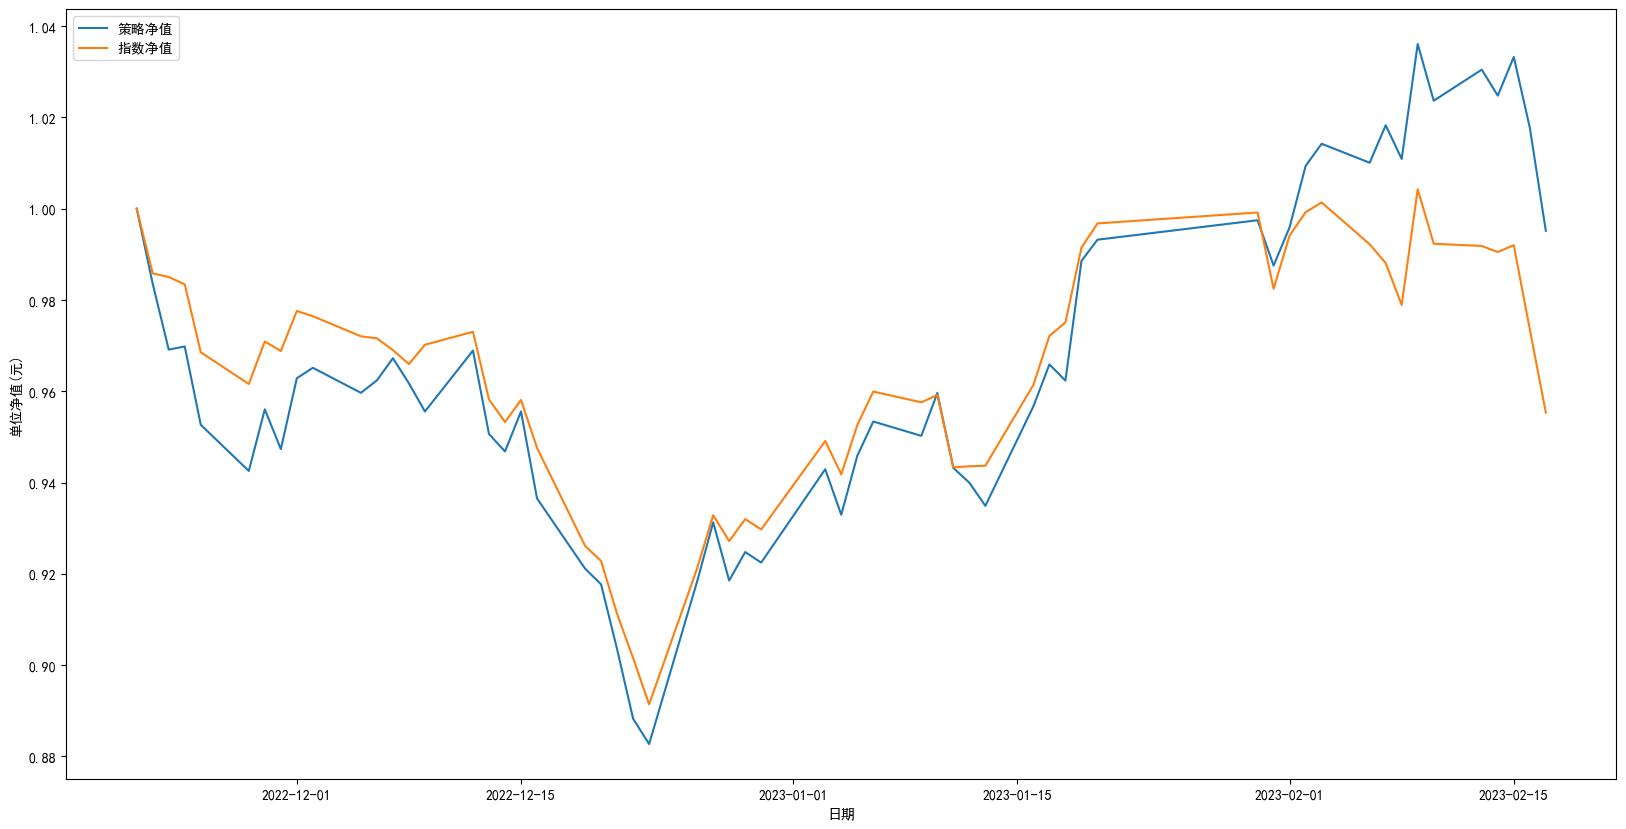

In [20]:
plt.figure(figsize=(20,10))
plt.plot(result.index,result['策略净值'],result.index,result['指数净值'], lw=1.5)
plt.legend(['策略净值','指数净值'])
plt.axis('tight')
plt.xlabel('日期')
plt.ylabel('单位净值(元)')

Res=pd.DataFrame(None,index=['期望收益率','收益率标准差','夏普比','最大回撤率'],columns=['策略','指数'])
ret = result/result.shift(1) - 1
# 平均收益率
Res.iloc[0,:]=ret.mean()
# 标准差
Res.iloc[1,:]=ret.std()
#夏普比率
Res.iloc[2,:]=(ret.mean()-0.03)/ret.std()*252**0.5
#最大回撤
for m in range(2):
    i=np.argmax((np.maximum.accumulate(result.iloc[:,m])-result.iloc[:,m]))
    if i==0:
        j=0
    else:
        j=np.argmax(result.iloc[:i,m])
    Res.iloc[3,m]=(result.iloc[j,m]-result.iloc[i,m])/result.iloc[j,m]
print(Res)